In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import re
import numpy as np
import pandas as pd

import SequenceDataORM as sqd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('C:/Users/Nicholas Sherer/.matplotlib/ShererPaper.mplstyle')

In [2]:
engine = create_engine('sqlite:///NS001_evolved_mutations_copy8.db', echo=False) # our database connection
session = sessionmaker(bind=engine)() # the session object is how we make queries through sqlalchemy

In [3]:
cd "Paper Figures"

C:\Users\Nicholas Sherer\Box\N_Sherer_Thesis_Materials\SeqDBandNBs\Paper Figures


# Ignoring ancestral polymorphisms, how many SNPs surpass a given frequency threshold for each sample?

In [4]:
ancestral_snps = [snp for snp in session.query(sqd.SNP_Mutation)
                  if ('Aggregate_NS001_Ancestors' in snp.samples) or
                     ('Ancestor_S1' in snp.samples) or
                     ('Ancestor_S2' in snp.samples) or
                     ('Ancestor_S3' in snp.samples)]
ancestral_snps = [snp for snp in ancestral_snps if len(snp.samples) <= 2]

In [5]:
def new_snps_above_frequency(sample, freq_cutoff):
    snps_above_frequency = [snp for snp in
                            (session.query(sqd.SNP_Mutation).join(sqd.SNP_Evidence)
                             .filter(sqd.SNP_Evidence.sample==sample)
                             .filter(sqd.SNP_Evidence.frequency >= freq_cutoff))]
    new_snps_above_freq = [snp for snp in snps_above_frequency
                           if ('Aggregate_NS001_Ancestors' not in snp.samples) and
                              ('Ancestor_S1' not in snp.samples) and
                              ('Ancestor_S2' not in snp.samples) and
                              ('Ancestor_S3' not in snp.samples)]
    return new_snps_above_freq

In [6]:
evolvedt1_samples = [smpl for smpl in session.query(sqd.DNA_Sample).filter(sqd.DNA_Sample.name.like('%t1%'))]
evolvedt2_samples = [smpl for smpl in session.query(sqd.DNA_Sample).filter(sqd.DNA_Sample.name.like('%t2%'))]

In [7]:
def mu_and_counts(samples, cutoff):
    mus = []
    counts = []
    names = []
    for sample in samples:
        mu = (session.query(sqd.Strain, sqd.MutationCondition)
                     .filter(sqd.Strain.mutation_rate_condition==sqd.MutationCondition.name)
                     .filter(sqd.Strain.name==sample.strain)
                     .first())[1].mu_est
        count = len(new_snps_above_frequency(sample.name, cutoff))
        mus.append(mu)
        counts.append(count)
        names.append(sample.name)
    mu_c_df = pd.DataFrame(data={'name': names, 'mu': mus, 'count': counts})
    return mu_c_df
    
def plot_snps_by_condition(mu_c_df, axes, color='r'):
    for row in mu_c_df.itertuples():
        axes.plot(row.mu, row.count, '.', color=color, markersize=12);
    means = mu_c_df.groupby(by='mu').mean()
    for row in means.itertuples():
        axes.plot(row.Index, row.count, '*', color=color, markersize=20, markeredgecolor='k')
    axes.set_xscale('log')
    ax.set_xlabel('mutation rate (rif resistance)', fontsize=20);
    ax.set_ylabel('number of mutations', fontsize=20);

In [8]:
def cumulative_mu_counts(sample):
    snps = [snp for snp in (session.query(sqd.SNP_Mutation).join(sqd.SNP_Evidence)
                                   .filter(sqd.SNP_Evidence.sample==sample)
                                   .order_by(sqd.SNP_Evidence.frequency))]
    new_snps = [snp for snp in snps if ('Aggregate_NS001_Ancestors' not in snp.samples) and
                                       ('Ancestor_S1' not in snp.samples) and
                                       ('Ancestor_S2' not in snp.samples) and
                                       ('Ancestor_S3' not in snp.samples) and
                                       (len(snp.samples) <= 2)]
    new_snp_evs = [(session.query(sqd.SNP_Evidence)
                           .filter(sqd.SNP_Evidence.sample==sample)
                           .filter(sqd.SNP_Evidence.chr_position==snp.chr_position)
                           .filter(sqd.SNP_Evidence.new_base==snp.new_base)
                           .first()) for snp in new_snps]
    new_snp_freqs = np.array([snp_ev.frequency for snp_ev in new_snp_evs])[::-1]
    counts = np.arange(1,len(new_snp_freqs)+1)
    return new_snp_freqs, counts

def func_cum(freqs, counts):
    def cum_dist(x):
        try:
            cl_idx = np.where(freqs>x)[0][-1]
        except IndexError:
            return 0
        return counts[cl_idx]
    return cum_dist

def mean_func(*args):
    def mmean(x):
        return np.mean([arg(x) for arg in args])
    return mmean

def median_func(*args):
    def mmedian(x):
        return np.median([arg(x) for arg in args])
    return mmedian

def min_func(*args):
    def mmin(x):
        return np.min([arg(x) for arg in args])
    return mmin

def max_func(*args):
    def mmax(x):
        return np.max([arg(x) for arg in args])
    return mmax

def std_func(*args):
    def mstd(x):
        return np.std([arg(x) for arg in args])
    return mstd

(1, 0.04)

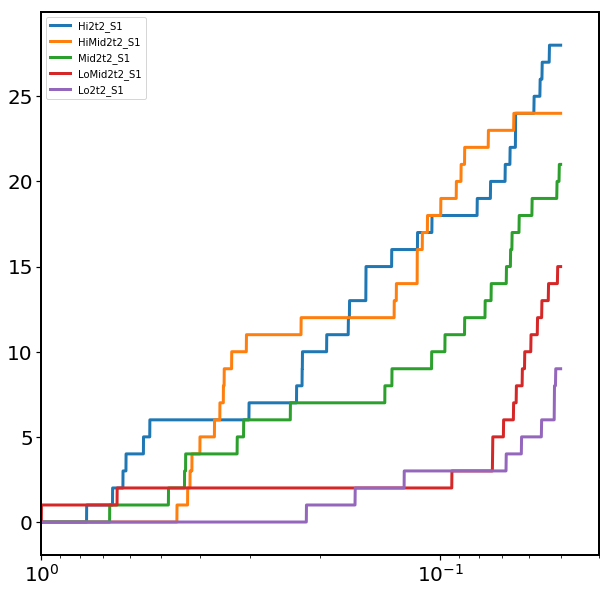

In [9]:
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(111)
for smpr in evolvedt2_samples:
    if smpr.name in ['Lo2t2_S1', 'LoMid2t2_S1', 'Mid2t2_S1', 'HiMid2t2_S1', 'Hi2t2_S1']:
        fraqs, cornts = cumulative_mu_counts(smpr.name)
        cumdist = func_cum(fraqs, cornts)
        x = np.linspace(1,.05,num=10000)
        y = np.array([cumdist(i) for i in x])
        axes.semilogx(x, y, '-', label=smpr.name)
axes.legend()
axes.set_xlim(1,.04)

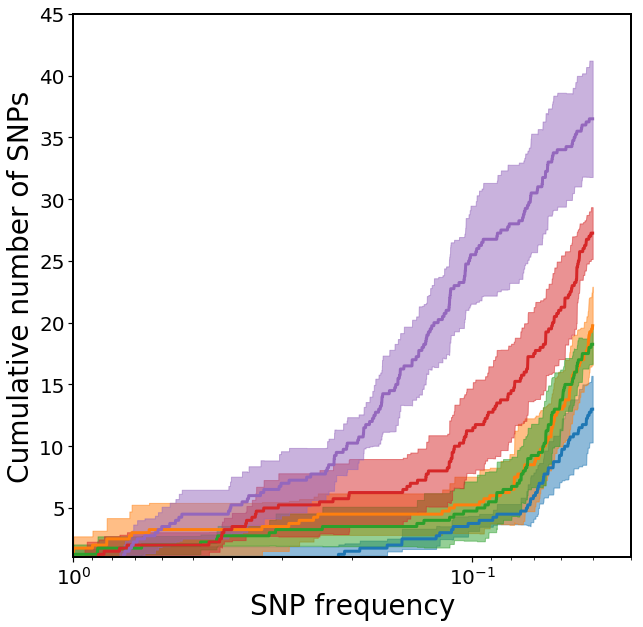

In [10]:
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(111)
x = np.linspace(1,.05,num=10000)

lodists = []
for smpr in ['Lo1t2_S1', 'Lo2t2_S1', 'Lo3t2_S1', 'Lo4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    lodists.append(cumdist)
min_low = min_func(*lodists)
max_low = max_func(*lodists)
mean_low = mean_func(*lodists)
std_low = std_func(*lodists)
y_low = np.array([mean_low(i) for i in x])
lns = axes.semilogx(x, y_low, '-', label='mean_low_cumulative')
color = lns[-1].get_color()
#axes.fill_between(x, [min_low(i) for i in x], [max_low(i) for i in x], color=color, alpha=.2)
axes.fill_between(x, [mean_low(i) - 1.1*2/3*std_low(i) for i in x],
                  [mean_low(i) + 1.1*2/3*std_low(i) for i in x], color=color, alpha=.5)

lomiddists = []
for smpr in ['LoMid1t2_S1', 'LoMid2t2_S1', 'LoMid3t2_S1', 'LoMid4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    lomiddists.append(cumdist)
min_lowmid = min_func(*lomiddists)
max_lowmid = max_func(*lomiddists)
mean_lowmid = mean_func(*lomiddists)
std_lowmid = std_func(*lomiddists)
y_lowmid = np.array([mean_lowmid(i) for i in x])
lns = axes.semilogx(x, y_lowmid, '-', label='mean_lowmid_cumulative')
color = lns[-1].get_color()
#axes.fill_between(x, [min_lowmid(i) for i in x], [max_lowmid(i) for i in x], color=color, alpha=.2)
axes.fill_between(x, [mean_lowmid(i) - 1.1*2/3*std_lowmid(i) for i in x],
                  [mean_lowmid(i) + 1.1*2/3*std_lowmid(i) for i in x], color=color, alpha=.5)

middists = []
for smpr in ['Mid1t2_S1', 'Mid2t2_S1', 'Mid3t2_S1', 'Mid4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    middists.append(cumdist)
min_mid = min_func(*middists)
max_mid = max_func(*middists)
mean_mid = mean_func(*middists)
std_mid = std_func(*middists)
y_mid = np.array([mean_mid(i) for i in x])
lns = axes.semilogx(x, y_mid, '-', label='mean_mid_cumulative')
color = lns[-1].get_color()
#axes.fill_between(x, [min_mid(i) for i in x], [max_mid(i) for i in x], color=color, alpha=.2)
axes.fill_between(x, [mean_mid(i) - 1.1*2/3*std_mid(i) for i in x],
                  [mean_mid(i) + 1.1*2/3*std_mid(i) for i in x], color=color, alpha=.5)

himiddists = []
for smpr in ['HiMid1t2_S1', 'HiMid2t2_S1', 'HiMid3t2_S1', 'HiMid4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    himiddists.append(cumdist)
min_himid = min_func(*himiddists)
max_himid = max_func(*himiddists)
mean_himid = mean_func(*himiddists)
std_himid = std_func(*himiddists)
y_himid = np.array([mean_himid(i) for i in x])
lns = axes.semilogx(x, y_himid, '-', label='mean_himid_cumulative')
color = lns[-1].get_color()
#axes.fill_between(x, [min_himid(i) for i in x], [max_himid(i) for i in x], color=color, alpha=.2)
axes.fill_between(x, [mean_himid(i) - 1.1*2/3*std_himid(i) for i in x],
                  [mean_himid(i) + 1.1*2/3*std_himid(i) for i in x], color=color, alpha=.5)

hidists = []
for smpr in ['Hi1t2_S1', 'Hi2t2_S1', 'Hi3t2_S1', 'Hi4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    hidists.append(cumdist)
min_hi = min_func(*hidists)
max_hi = max_func(*hidists)
mean_hi = mean_func(*hidists)
std_hi = std_func(*hidists)
y_hi = np.array([mean_hi(i) for i in x])
lns = axes.semilogx(x, y_hi, '-', label='mean_hi_cumulative')
color = lns[-1].get_color()
#axes.fill_between(x, [min_hi(i) for i in x], [max_hi(i) for i in x], color=color, alpha=.2)
axes.fill_between(x, [mean_hi(i) - 1.1*2/3*std_hi(i) for i in x],
                  [mean_hi(i) + 1.1*2/3*std_hi(i) for i in x], color=color, alpha=.5)

#axes.legend()
axes.set_xlim(1,.04)
axes.set_ylim(1,45)
axes.set_xlabel('SNP frequency')
axes.set_ylabel('Cumulative number of SNPs')
plt.savefig('Cumulative_SNPs_at_day_41.pdf')

(1, 0.04)

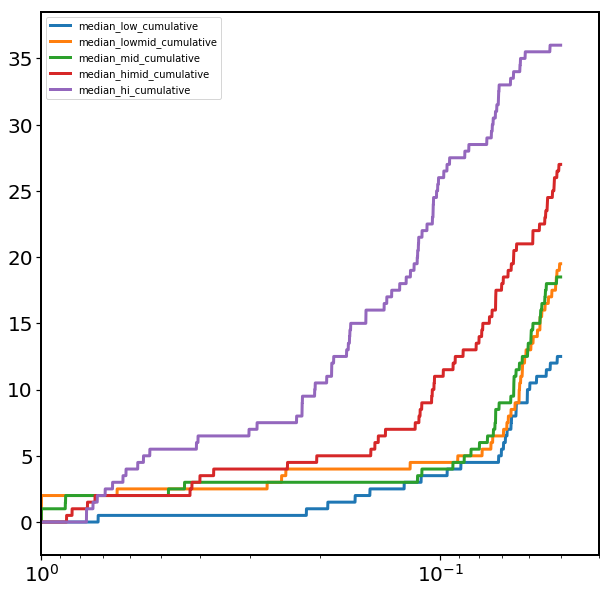

In [11]:
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(111)
x = np.linspace(1,.05,num=10000)

lodists = []
for smpr in ['Lo1t2_S1', 'Lo2t2_S1', 'Lo3t2_S1', 'Lo4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    lodists.append(cumdist)
mean_low = median_func(*lodists)
y_low = np.array([mean_low(i) for i in x])
axes.semilogx(x, y_low, '-', label='median_low_cumulative')

lomiddists = []
for smpr in ['LoMid1t2_S1', 'LoMid2t2_S1', 'LoMid3t2_S1', 'LoMid4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    lomiddists.append(cumdist)
mean_lowmid = median_func(*lomiddists)
y_lowmid = np.array([mean_lowmid(i) for i in x])
axes.semilogx(x, y_lowmid, '-', label='median_lowmid_cumulative')

middists = []
for smpr in ['Mid1t2_S1', 'Mid2t2_S1', 'Mid3t2_S1', 'Mid4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    middists.append(cumdist)
mean_mid = median_func(*middists)
y_mid = np.array([mean_mid(i) for i in x])
axes.semilogx(x, y_mid, '-', label='median_mid_cumulative')

himiddists = []
for smpr in ['HiMid1t2_S1', 'HiMid2t2_S1', 'HiMid3t2_S1', 'HiMid4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    himiddists.append(cumdist)
mean_himid = median_func(*himiddists)
y_himid = np.array([mean_himid(i) for i in x])
axes.semilogx(x, y_himid, '-', label='median_himid_cumulative')

hidists = []
for smpr in ['Hi1t2_S1', 'Hi2t2_S1', 'Hi3t2_S1', 'Hi4t2_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    hidists.append(cumdist)
mean_hi = median_func(*hidists)
y_hi = np.array([mean_hi(i) for i in x])
axes.semilogx(x, y_hi, '-', label='median_hi_cumulative')

axes.legend()
axes.set_xlim(1,.04)

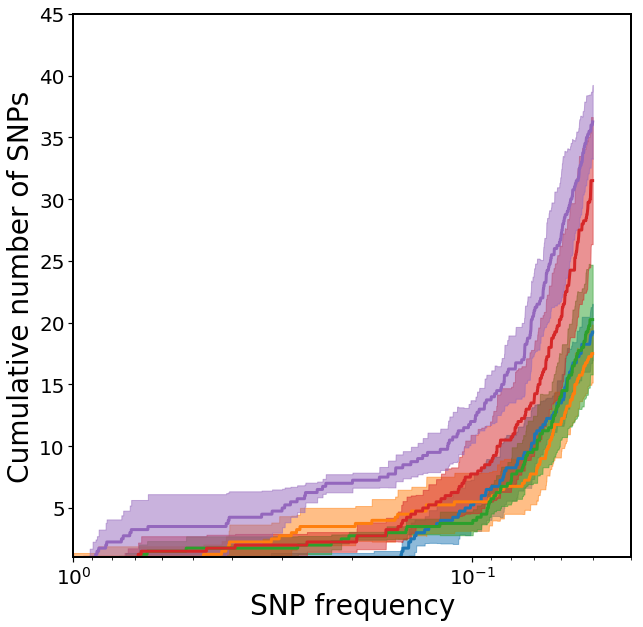

In [12]:
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(111)
x = np.linspace(1,.05,num=10000)

lodists = []
for smpr in ['Lo1t1_S1', 'Lo2t1_S1', 'Lo3t1_S1', 'Lo4t1_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    lodists.append(cumdist)
min_low = min_func(*lodists)
max_low = max_func(*lodists)
mean_low = mean_func(*lodists)
std_low = std_func(*lodists)
y_low = np.array([mean_low(i) for i in x])
lns = axes.semilogx(x, y_low, '-', label='mean_low_cumulative')
color = lns[-1].get_color()
#axes.fill_between(x, [min_low(i) for i in x], [max_low(i) for i in x], color=color, alpha=.2)
axes.fill_between(x, [mean_low(i) - 1.1*2/3*std_low(i) for i in x],
                  [mean_low(i) + 1.1*2/3*std_low(i) for i in x], color=color, alpha=.5)

lomiddists = []
for smpr in ['LoMid1t1_S1', 'LoMid2t1_S1', 'LoMid3t1_S1', 'LoMid4t1_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    lomiddists.append(cumdist)
min_lowmid = min_func(*lomiddists)
max_lowmid = max_func(*lomiddists)
mean_lowmid = mean_func(*lomiddists)
std_lowmid = std_func(*lomiddists)
y_lowmid = np.array([mean_lowmid(i) for i in x])
lns = axes.semilogx(x, y_lowmid, '-', label='mean_lowmid_cumulative')
color = lns[-1].get_color()
#axes.fill_between(x, [min_lowmid(i) for i in x], [max_lowmid(i) for i in x], color=color, alpha=.2)
axes.fill_between(x, [mean_lowmid(i) - 1.1*2/3*std_lowmid(i) for i in x],
                  [mean_lowmid(i) + 1.1*2/3*std_lowmid(i) for i in x], color=color, alpha=.5)
middists = []
for smpr in ['Mid1t1_S1', 'Mid2t1_S1', 'Mid3t1_S1', 'Mid4t1_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    middists.append(cumdist)
min_mid = min_func(*middists)
max_mid = max_func(*middists)
mean_mid = mean_func(*middists)
std_mid = std_func(*middists)
y_mid = np.array([mean_mid(i) for i in x])
lns = axes.semilogx(x, y_mid, '-', label='mean_mid_cumulative')
color = lns[-1].get_color()
#axes.fill_between(x, [min_mid(i) for i in x], [max_mid(i) for i in x], color=color, alpha=.2)
axes.fill_between(x, [mean_mid(i) - 1.1*2/3*std_mid(i) for i in x],
                  [mean_mid(i) + 1.1*2/3*std_mid(i) for i in x], color=color, alpha=.5)

himiddists = []
for smpr in ['HiMid1t1_S1', 'HiMid2t1_S1', 'HiMid3t1_S1', 'HiMid4t1_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    himiddists.append(cumdist)
min_himid = min_func(*himiddists)
max_himid = max_func(*himiddists)
mean_himid = mean_func(*himiddists)
std_himid = std_func(*himiddists)
y_himid = np.array([mean_himid(i) for i in x])
lns = axes.semilogx(x, y_himid, '-', label='mean_himid_cumulative')
color = lns[-1].get_color()
#axes.fill_between(x, [min_himid(i) for i in x], [max_himid(i) for i in x], color=color, alpha=.2)
axes.fill_between(x, [mean_himid(i) - 1.1*2/3*std_himid(i) for i in x],
                  [mean_himid(i) + 1.1*2/3*std_himid(i) for i in x], color=color, alpha=.5)
hidists = []
for smpr in ['Hi1t1_S1', 'Hi2t1_S1', 'Hi3t1_S1', 'Hi4t1_S1']:
    fraqs, cornts = cumulative_mu_counts(smpr)
    cumdist = func_cum(fraqs, cornts)
    hidists.append(cumdist)
min_hi = min_func(*hidists)
max_hi = max_func(*hidists)
mean_hi = mean_func(*hidists)
std_hi = std_func(*hidists)
y_hi = np.array([mean_hi(i) for i in x])
lns = axes.semilogx(x, y_hi, '-', label='mean_hi_cumulative')
color = lns[-1].get_color()
#axes.fill_between(x, [min_hi(i) for i in x], [max_hi(i) for i in x], color=color, alpha=.2)
axes.fill_between(x, [mean_hi(i) - 1.1*2/3*std_hi(i) for i in x],
                  [mean_hi(i) + 1.1*2/3*std_hi(i) for i in x], color=color, alpha=.5)

#axes.legend()
axes.set_xlim(1,.04)
axes.set_ylim(1,45)
axes.set_xlabel('SNP frequency')
axes.set_ylabel('Cumulative number of SNPs')
plt.savefig('Cumulative_SNPs_at_day_24.pdf')

# Comparing to immediate ancestor at time t1 instead of original ancestor

In [13]:
def new_snps_above_t1frequency(sample, freq_cutoff):
    if 't2' not in sample:
        raise ValueError('Need a sample from time t2')
    snps_above_frequency = [snp for snp in
                            (session.query(sqd.SNP_Mutation).join(sqd.SNP_Evidence)
                             .filter(sqd.SNP_Evidence.sample==sample)
                             .filter(sqd.SNP_Evidence.frequency >= freq_cutoff))]
    ancestor_sample_name = re.sub('t2', 't1', sample)
    new_snps_above_freq = [snp for snp in snps_above_frequency
                           if ('Aggregate_NS001_Ancestors' not in snp.samples) and
                              ('Ancestor_S1' not in snp.samples) and
                              ('Ancestor_S2' not in snp.samples) and
                              ('Ancestor_S3' not in snp.samples) and
                              (ancestor_sample_name not in snp.samples)]
    return new_snps_above_freq

def mu_and_counts_reft1(samples, cutoff):
    mus = []
    counts = []
    names = []
    for sample in samples:
        mu = (session.query(sqd.Strain, sqd.MutationCondition)
                     .filter(sqd.Strain.mutation_rate_condition==sqd.MutationCondition.name)
                     .filter(sqd.Strain.name==sample.strain)
                     .first())[1].mu_est
        count = len(new_snps_above_t1frequency(sample.name, cutoff))
        mus.append(mu)
        counts.append(count)
        names.append(sample.name)
    mu_c_df = pd.DataFrame(data={'name': names, 'mu': mus, 'count': counts})
    return mu_c_df